# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Добейтесь значения MAE на тестовой выборке не больше 8.

# План работы над проектом

* Исследовательский анализ набора фотографий.
* Подготовить данные к обучению.
* Обучить нейронную сеть и рассчитать её качество.

# Исследовательский анализ данных

In [1]:
# Базовые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# загружаем изображения

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batchhttps://colab.research.google.com/drive/1Cqw_Jf89t-0TdA8G4RWIRhkPy2cCmTuz#scrollTo=hSzFJq3FdIoI_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head() # выводим часть датафрейма

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.describe() # выводим статистики

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
# Размер выборки

print('Размер выборки составляет', labels.shape[0], 'фотографий')

Размер выборки составляет 7591 фотографий


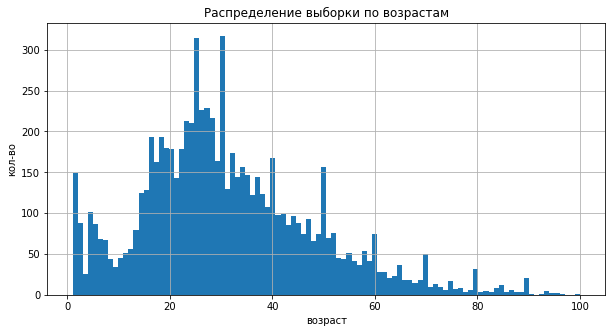

In [6]:
# график распределения выборки по возрастам

labels.real_age.hist(bins=100, figsize=(10, 5))
plt.title('Распределение выборки по возрастам')
plt.xlabel('возраст')
plt.ylabel('кол-во')
None

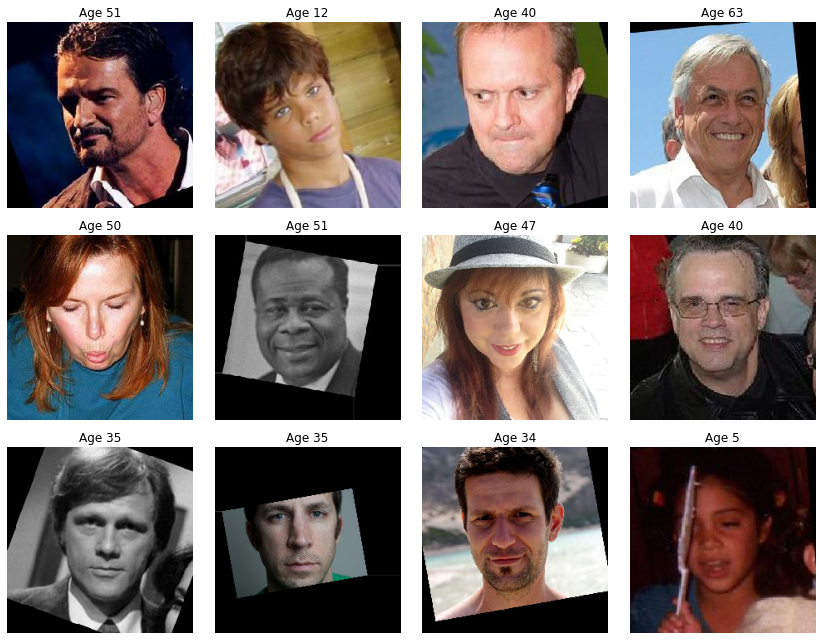

In [7]:
# Выводим 12 изображений

fig = plt.figure(figsize=(12,9))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(np.array(train_gen_flow[1][0][i]), cmap='gray')
    plt.title(f'Age {train_gen_flow[1][1][i]}')
    plt.axis('off')
    plt.tight_layout()

**Выводы**

1. Данные представляют собой датафрейм из 7591 объекта - пары "изображение лица" и "возраст человека".

2. Распределение объектов по возрасту неравномерное, напоминает распределение Пуассона. 

3. Средний возраст - 31.2 года, стандартное отклонение - 17.14 лет.

4. Пик распределения приходится на возраст 25-30 лет (более 1100 объектов).

5. Медиана - 29 лет.

6. Есть всплески на возрастах, кратных 5 (возможное округление при разметке).

7. Мало объектов с возрастом старше 60 лет. 

8. Требуется выровнять распределение для равной вероятности предсказания разных возрастов.

9. Изображения имеют различные артефакты. Часть изображений повернуты и имеют фон, также меняется качество от картинки к картинке. Изображения имеют различия по резкости, контрастности, есть черно-белые изображения. Все эти особенности нужно учитывать.

# Обучение модели

In [8]:
# код модели

# библиотеки
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalMaxPool2D
    

# загрузка данных
def load_train(path):
    dataframe = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1.0/255, validation_split=0.25,
        horizontal_flip=True
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=12345,
        subset='training'
    )
    return train_datagen_flow


def load_test(path):
    dataframe = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=12345,
        subset='validation'
    )
    return test_datagen_flow


# создание модели
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPool2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


# тренировка модели
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

Результаты:    
    
    Found 5694 validated image filenames.
    Found 1897 validated image filenames.

    <class 'tensorflow.python.keras.engine.sequential.Sequential'>

    Train for 178 steps, validate for 60 steps
    Epoch 1/10
    178/178 - 47s - loss: 182.0882 - mae: 10.0400 - val_loss: 849.0625 - val_mae: 24.2124
    Epoch 2/10
    178/178 - 39s - loss: 64.8348 - mae: 6.0039 - val_loss: 732.0903 - val_mae: 21.9983
    Epoch 3/10
    178/178 - 41s - loss: 39.4025 - mae: 4.7254 - val_loss: 384.5692 - val_mae: 14.6959
    Epoch 4/10
    178/178 - 43s - loss: 29.9011 - mae: 4.0558 - val_loss: 129.8738 - val_mae: 8.8269
    Epoch 5/10
    178/178 - 43s - loss: 23.1564 - mae: 3.5459 - val_loss: 82.7459 - val_mae: 6.9946
    Epoch 6/10
    178/178 - 44s - loss: 19.0401 - mae: 3.2605 - val_loss: 78.5476 - val_mae: 6.7019
    Epoch 7/10
    178/178 - 51s - loss: 17.2815 - mae: 3.1328 - val_loss: 77.4341 - val_mae: 6.6419
    Epoch 8/10
    178/178 - 52s - loss: 15.1844 - mae: 2.9566 - val_loss: 68.1713 - val_mae: 6.3814
    Epoch 9/10
    178/178 - 50s - loss: 13.7865 - mae: 2.7891 - val_loss: 73.4194 - val_mae: 6.4412
    Epoch 10/10
    178/178 - 52s - loss: 13.5414 - mae: 2.7472 - val_loss: 75.6690 - val_mae: 6.6908

    60/60 - 10s - loss: 75.6690 - mae: 6.6908
    Test MAE: 6.6908

**Анализ обученной модели:**
* Для загрузки данных был использован специальный загрузчик ImageDataGenerator.
* Данные были приведены к единому формату 224х224, значения пикселей нормализованы.
* Была построена модель на основе архитектуры ResNet50.
* Добавлен слой MaxPooling() и 2 полносвязных слоя с функцией активации RELU. Первый слой имеет 128 нейронов, выходной слой состоит из 1 нейрона.
* В качестве функции потерь была выбрана MSE, метрика качества - MAE.
* Модель обучалась в течение 10 эпох.
* Финальная MAE на тестовой выборке составила 6.6908 что укладывается в целевые показатели.

# Итоговый вывод

Проведено обучение нейронной сети для определения возраста человека по фотографии. В качестве архитектуры сети была выбрана ResNet50 - современная глубокая архитектура, показывающая лучшие результаты на различных задачах компьютерного зрения.

Для обучения использовался датасет, содержащий пары "фотография лица - возраст". Общее количество объектов в датасете составило 7591 запись. При этом распределение объектов по возрастам оказалось неравномерным.

Наибольшее количество фотографий принадлежит людям в возрасте 25-30 лет (свыше 1100 записей). В то же время, объектов с изображениями детей и пожилых людей существенно меньше. Такая диспропорция может привести к худшему качеству распознавания возраста в этих группах.

После обучения модель протестировали на валидационной выборке. Результат оказался достаточно хорошим - средняя абсолютная ошибка составила 6.69 года. Это меньше целевого показателя в 8 лет.

Полученную модель можно использовать в прикладных задачах анализа поведения потребителей, где точность в 6-7 лет приемлема. Однако для ответственных задач вроде проверки возраста при продаже алкоголя данная модель не подходит.

В целом результат обучения можно считать успешным. Использование GPU и глубокой нейросети позволило эффективно обработать большой объем данных. В то же время, есть возможности для улучшения качества модели в будущем за счет расширения и выравнивания обучающей выборки.

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> дополнительные материалы </b>
В курсе уже есть ссылки на отдельные статьи. Со своей стороны поделюсь неплохими бесплатными курсами по нейронкам, дающим целостную картинку.
    
   - "Дип Лернинг на пальцах" (https://www.youtube.com/playlist?list=PL5FkQ0AF9O_o2Eb5Qn8pwCDg7TniyV1Wb).
   - Отличный бесплатный курс от Школы глубокого обучения МФТИ (https://stepik.org/org/dlschool), старт курса каждые пол года. Два семестра, один по основам и компьютерному зрению, второй по обработке естественного языка.
   - "Нейронные сети и компьютерное зрение" от Samsung Research Russia (https://stepik.org/course/50352/syllabus). Есть также продолжение по NLP.  

</div>